In [1]:
import numpy as np
import scipy as scp

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pandas as pd

import sys

import warnings

import ipywidgets as widgets

import warnings

import multiprocessing
import h5py
import pickle

"""
check python version
"""
import platform
     
print(platform.python_version())

"""
make anaconda available
"""
import sys



"""
create environmental variable "MKL_THREADING_LAYER"
"""
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"


"""
check theano version and config file
"""
import theano
#print(theano.__version__)
#print(theano.config)


"""
import  Delfi package
"""
sys.path.append('/gpfs01/berens/user/cschroeder/Documents/Ribbon_PR_project/delfi')
import delfi
import delfi.distribution as dd
from delfi.inference import SNPE
from delfi.simulator.BaseSimulator import BaseSimulator
from delfi.summarystats import Identity
from delfi.generator import Default
from delfi.generator.BaseGenerator import BaseGenerator

#from delfi.distribution import MixedDistribution
from delfi import kernel
from delfi.kernel.BaseKernel import BaseKernel
from delfi.summarystats.BaseSummaryStats import BaseSummaryStats



3.8.0


Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'In file included from /tmp/try_flags__gb54oxs.c:4:0:\n/usr/include/cudnn.h:56:10: fatal error: cuda_runtime.h: No such file or directory\n #include <cuda_runtime.h>\n          ^~~~~~~~~~~~~~~~\ncompilation terminated.\n'
Mapped name None to device cuda: NVIDIA GeForce RTX 2080 Ti (0000:2F:00.0)


### load data

In [2]:
# load data

# open file
f = h5py.File("data_reextracted.hdf5", "r")

wave_normal = np.array(f['wave_control'])
wave_blocked = np.array(f['wave_blocked'])
wavelength = np.array(f['wavelength'])
opsins = np.array(f['opsins'])

for item in f.attrs:
    print(item, f.attrs[item])

f.close()

wave_blocked_raw = np.copy(wave_blocked)
wave_control_raw = np.copy(wave_normal)
opsins_raw = np.copy(opsins)

# normalizing
for i in range(4):
    wave_blocked[i] = wave_blocked[i] - np.min(wave_blocked[i])
    wave_blocked[i] = wave_blocked[i] / np.max(abs(wave_blocked[i]))
    
    wave_normal[i] = wave_normal[i] / np.max(abs(wave_normal[i]))
    
    opsins[i] =  opsins[i] - np.max(opsins[i])
    opsins[i] =  opsins[i] / np.min(opsins[i])



info: cone signals under normal and rescaled conditions. In order R,G,B,UV, aligned to wavelength axis. Same for opsins.


Text(0.5, 0, 'wavelength')

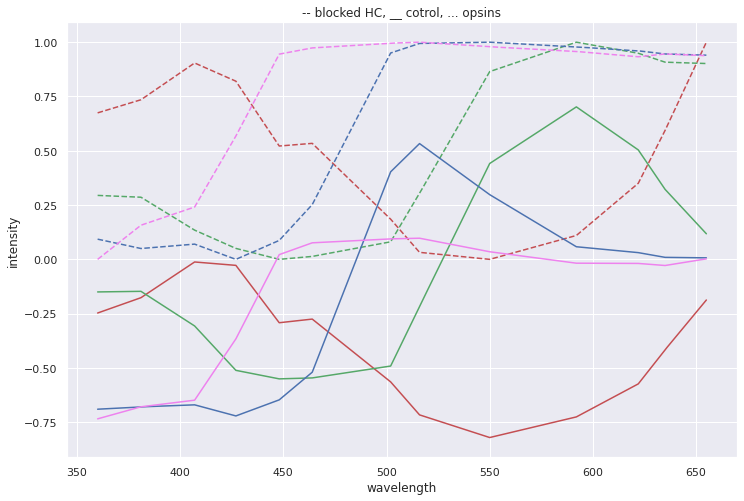

In [3]:
colors = ['r', 'g', 'b','violet' ]


plt.figure(figsize=(12,8))

plt.title('-- blocked HC, __ cotrol, ... opsins')
for i in range(4):
    plt.plot(wavelength, wave_blocked[i], '--', color=colors[i], label='blocked')
    #plt.plot(wavelength, opsins[i], ':', color=colors[i], label='opsins')


for i in range(4):
    plt.plot(wavelength, wave_control_raw[i], color=colors[i], label='control condition')

plt.ylabel('intensity')
plt.xlabel('wavelength')
#plt.legend()

In [4]:
"""
load model
"""

from hc_model import run_model_hc
from hc_model import extract_params
from hc_model import get_param_labels


# specify modes
modes = [['HC0', 'HC1', 'HC2'],
 ['HC0', 'HC1'],
 ['HC0', 'HC2'],
 ['HC1', 'HC2'],
 ['HC0'],
 ['HC1'],
 ['HC2'],
 'special']



# number of params per mode
#mode_params = [11,8,7,7,4,4,3]
mode_params = [12,9,8,7,5,4,3,13]



In [8]:
get_param_labels('special')

['w00',
 'w01',
 'w02',
 'w03',
 'w10',
 'w11',
 'w12',
 'w13',
 'w22',
 'w23',
 'a0',
 'a1',
 'a2']

In [9]:
"""
run without HC
"""

o = wave_blocked

# connectivity pattern
# initialize by c for found connections
const = 1
w = np.zeros((3,4))
#w[0,0]= const
#w[0,1] = const
#w[0,2] = const
#w[1,1] = const
#w[1,2] = const
#w[1,3] = const
#w[2,2] = const
#w[2,3] = const

# synaptic (output) strength per HC (HC_j -> cone) (constant over the different cone types)
a = np.zeros(3)

# dark current (can also be seen as synaptic strength cone_i -> HC )
# fixed here
dc = np.ones(4)
#dc[0] = dc0
#dc[1] = dc1
#dc[2] = 0.5
#dc[3] = 2
    


k_no_HC = run_model_hc(o,w, dc,a, N=200)

#loss_noHC = get_loss(k_data,k_no_HC)

In [15]:
from parallel_running import mse
mse_noHC = mse(k_no_HC.flatten(), wave_normal.flatten())


In [25]:
mse_noHC

0.327282196924212

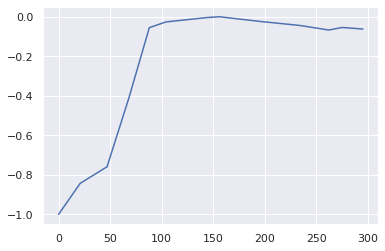

In [26]:
plt.plot(k_no_HC[3])

In [27]:
"""
!!!! model output is 4x296 !!!
"""
def run_model_x(params, o, mode, N=200):
    """
    helper to extract parameters
    and set params 0 if negative
    """
    
    w,dc,a = extract_params(params,mode)
    
    # set to 0 if negative
    w[w<0] = 0 
    dc[dc<0] = 0 
    a[a<0] = 0 
    
    
    k_fit = run_model_hc(o,w,dc,a,N=N)
    
    return k_fit #, baseline_store

"""
own generator class
"""
class myGenerator(BaseGenerator):
    def __init__(self, *args, gen_minibatch, **kwargs):
        super().__init__(*args, **kwargs)
        self.gen_minibatch = gen_minibatch

    def gen(self, *args, **kwargs):
        if 'minibatch' in kwargs:
            minibatch = kwargs.pop('minibatch')
        else:
            minibatch = self.gen_minibatch
        return super().gen(*args, minibatch=minibatch, **kwargs)


"""
Define simulator class
"""
class HC_Class(BaseSimulator):
    def __init__(self, simulator, opsins, mode, dim=1, seed=None):
        """
        Model of HC cone interaction in zebrafish
        Parameters
        ----------
        
        seed : int or None
            If set, randomness is seeded
        """
        super().__init__(dim_param=dim, seed=seed)
        self.opsins = opsins
        self.simulate1 = simulator 
        self.mode = mode
        
        
    def gen_single(self, params):
        """
        run one simulation of the model
        ------
        params : 1 dim array
        """        
        params = np.asarray(params).reshape(-1)
        assert params.ndim == 1
        assert params.shape[0] == self.dim_param


        sample = self.simulate1( params, self.opsins, self.mode)

        return {'data': sample.reshape(-1)}

    def run_parallel(self, *params):
        """
        runs simNormalized in a for loop, with n = len(params)
        to be used in multiprocessing - starmap
        """
        #print(len(params))
        result = []
        for i in range(0,len(params)):
            result_single = self.simulate1(params[i], self.opsins, self.mode)
            result.append({'data':result_single.reshape(-1)})
        return result
    
    '''    
    # from base class
    def gen(self, params_list, n_reps=1, pbar=None):
        """Forward model for simulator for list of parameters
        Parameters
        ----------
        params_list : list of lists or 1-d np.arrays
            List of parameter vectors, each of which will be simulated
        n_reps : int
            If greater than 1, generate multiple samples given param
        pbar : tqdm.tqdm or None
            If None, will do nothing. Otherwise it will call pbar.update(1)
            after each sample.
        Returns
        -------
        data_list : list of lists containing n_reps dicts with data
            Repetitions are runs with the same parameter set, different
            repetitions. Each dictionary must contain a key data that contains
            the results of the forward run. Additional entries can be present.
        """
        data_list = []
        for param in params_list:
            rep_list = []
            for r in range(n_reps):
                rep_list.append(self.gen_single(param))
            data_list.append(rep_list)
            if pbar is not None:
                pbar.update(1)

        return data_list
    '''
        

    
    
    # adapted gen for parallel processing
    # n_reps > 1 not yet implemented!!!
    def gen(self, params_list, n_reps=1, pbar=None, verbose = False, skip_feedback=False, prior_mixin=0,
            minibatch=100, keep_data=True, from_prior=False,):
        """Forward model for simulator for list of parameters
        Parameters
        ----------
        params_list : list of lists or 1-d np.arrays
            List of parameter vectors, each of which will be simulated
        n_reps : int
            If greater than 1, generate multiple samples given param
                TODO: not yet implemented in parallel run!!!
        pbar : tqdm.tqdm or None
            If None, will do nothing. Otherwise it will call pbar.update(1)
            after each sample.
        Returns
        -------
        data_list : list of lists containing n_reps dicts with data
            Repetitions are runs with the same parameter set, different
            repetitions. Each dictionary must contain a key data that contains
            the results of the forward run. Additional entries can be present.
        """
        # specify used cpus (should be intelligently chosen to minibatchsize)
        pr = 41 # 26
        
        # calc runs per cpu (last cpu is left for remainder of division)
        singlejobs = round(np.shape(params_list)[0]/(pr-1))
        
        # reshape params_list
        fitparams = list([])
        for i in range(0,pr-1):
            fitparams.append(params_list[i*singlejobs:(i+1)*singlejobs])
        fitparams.append(params_list[(i+1)*singlejobs:])
        # runs parallel the simulations
        with multiprocessing.Pool(processes=pr) as pool:
            JexoMult = pool.starmap(self.run_parallel, fitparams)
        
        
        
        # reshape the simulated data
        data_list = []
        for i in range(np.shape(JexoMult)[0]):
            for j in range(np.shape(JexoMult[i])[0]):
                rep_list = []
                rep_list.append(JexoMult[i][j])
                data_list.append(rep_list)
                if pbar is not None:
                    pbar.update(1)
                
        return data_list

    
"""
create summary statistics
"""
def mse(fit, data):
    """
    compute sqrt(mse)!!!
    """
    #mse = 1/(np.shape(data)[0]*np.shape(data)[1]) * np.sum((data - fit)**2)
    mse = 1/(len(data)) * np.sum((data - fit)**2)
    #if mse >20:
    #    mse = 100
    if np.isnan(mse):
        #raise Warning('mse is Nan. Check your model.')
        return 10e3
    else:
        return min(np.sqrt(mse), 10e3)

class MseSS(BaseSummaryStats):
    """
    Reduces data to mse
    """

    def __init__(self, data, seed=None):
        super().__init__(seed=seed)
        # should return a matrix n_samples x 1 (mse)
        self.n_summary = 1
        self.data = data

    @copy_ancestor_docstring
    def calc(self, repetition_list):
        # See BaseSummaryStats.py for docstring

        # get the number of repetitions contained
        n_reps = len(repetition_list)

        # build a matrix of n_reps x 1
        repetition_stats_matrix = np.zeros((n_reps, self.n_summary))

        # for every repetition, take the mean of the data in the dict
        for rep_idx, rep_dict in enumerate(repetition_list):
            repetition_stats_matrix[rep_idx, ] = mse(rep_dict['data'], self.data)

        return repetition_stats_matrix
    

In [28]:
class DELFI_HC():
    def  __init__(self, opsins, mode,  nparams, recorded_data):
        self.opsins = opsins
        self.mode = mode
        self.nparams = nparams
        self.recorded_data = recorded_data
    
    def initialize_model(self, prior):
        """initialize model"""
            
        # define prior
        if prior =='gauss':
            mean_start = np.ones(self.nparams)#*0.5
            self.prior = dd.Gaussian(m = mean_start , S=np.eye(self.nparams)*0.03)
            
        elif prior == 'uniform':
            self.prior = dd.Uniform(lower= np.zeros(nparams), upper= np.ones(nparams)*3)
        else:
            raise NameError('This prior is not yet implemented.')
        
        
        # initialize summary statistics 
        self.s = MseSS(self.recorded_data) 
        
        # initialize model
        self.m = HC_Class(run_model_x, self.opsins, self.mode, dim=self.nparams)
        self.generator = myGenerator(model= self.m, prior= self.prior, summary=self.s, gen_minibatch=1000) 
        #BaseGenerator(model= self.m, prior= self.prior, summary=self.s)
     
        
        
        
        
        ##########################################################################################
        
    def infer_params(self, rounds, n_train, x0 = None,
                     save=True, filename = None, 
                     bw=1, q=None):

        """
        run the inference algorithme in mulitple rounds
        ---
        params:
        : rounds:    number of rounds
        : nr_train:  number of samples per round (int or list of int) [100000, 10000]
        : bw:        bandwidht of Gauss-kernel
        """
        folderpath = 'SNPE_data/'
        
        # raise error if no filename is specified
        if save:
            if filename == None:
                raise NameError('No filename for saving specified.')
                
            filelist = os.listdir(folderpath)
            
            if filename in filelist:
                raise NameError('Filename already exists.')
        
        # observed data 
        xo = x0 #np.array([x0])

        starttime = datetime.datetime.now()
        print('Starting time for inference:', starttime)

        # set kernel
        kernel = delfi.kernel.HalfGauss(xo)#, bandwidth=bw) #delfi.kernel.Gauss(xo, bandwidth=bw)
        
        # initialize
        inf_snpe = SNPE(generator=self.generator,
                        prior_mixin=0, # mix additional N*prior_mixin samples into samples from proposal prior
                        n_components=3, 
                        n_hiddens=[40,40], 
                        obs=xo,
                        pseudo_obs_perc= 0.5, 
                        pseudo_obs_n= None,
                        kernel_bandwidth_perc=30,
                        kernel_bandwidth_n= None,
                        kernel_bandwidth_min=0.05,
                        pseudo_obs_use_all_data= False,
                        pilot_samples=None, 
                        kernel=kernel, 
                        svi=False,
                        reg_lambda=0.01, # precision parameter in svi, default 0.01
                        impute_missing=True,
                        init_trn_data_folder= mode,#'flashtds',
                        verbose=True) 
        
        #if changing_obs:
        #    if not len(x0)==rounds:
        #        raise NameError('length of x0  does not match the number of rounds.')
                
        
        # returning loss of DNN, (params, simulations), posteriors (for each round)
        logs, tds, posteriors = inf_snpe.run(n_train=n_train, 
                                             n_rounds=rounds, 
                                             proposal = self.prior, 
                                             epochs= 800,#800, 
                                             minibatch= 500, #500 
                                             stop_on_nan=True,
                                             monitor= None,  #{'missing':missing}, ????
                                             save_trn_data=True,
                                             load_trn_data= True,
                                             append_trn_data=True,
                                             init_tds_file='test',
                                             round_cl=3) #init_trn_data_folder= 'flashtds_decay_singlerise_D1',
        

        runtime = datetime.datetime.now() - starttime
        print('Runtime: ',runtime, ' in total' )
        print()


        if save:
            """
            saving the posteriors
            """
            filepath = folderpath+filename
            info = '{} rounds, n_train = {} , SNPE, n_components=3, n_hiddens=[80,80],obs={}, \
                    pilot_samples=None, 1000 epochs, minibatch=500, uniform prior,prior_mixin=0, bandwidth={}, svi=False\
                    kernel=gauss,SS=MSE, runtime: {:.5} min'.format(rounds, samples,x0,bw, runtime.total_seconds()/60)
            #print(info)
            
            saveobject = dict({'posterior': posteriors, 
                               'logs':logs,
                               'SNPE_info': info,
                              'tds':tds})
            pickle.dump( saveobject, open(filepath, "wb" ) )

        return logs, tds, posteriors, inf_snpe

In [29]:
modes

[['HC0', 'HC1', 'HC2'],
 ['HC0', 'HC1'],
 ['HC0', 'HC2'],
 ['HC1', 'HC2'],
 ['HC0'],
 ['HC1'],
 ['HC2'],
 'special']

In [99]:
"""
loading the posteriors 
"""


 # load object
folderpath = '/gpfs01/berens/user/cschroeder/Documents/Biophysical Models/Cone_HC_interaction/Delfi/fit_results/v2/'
filename =  'mode7_0.pkl'
filepath = folderpath+filename

with open(filepath, "rb") as f:
    load_object = pickle.load(f)
    posteriors = load_object['posterior']
    logs = load_object['logs']
    tds = load_object['tds']
    inf_snpe = load_object['model']
    info = load_object['SNPE_info']
    mode = load_object['mode']

print('loaded mode:', mode)
print(info)

print()

nparams = len(tds[0][0][0])
print('number of parameters:',nparams)

loaded mode: special
5 rounds, n_train = 200000 , SNPE, n_components=3, n_hiddens=[100,100],obs=[[0]], 0.01pseudo_obs             pilot_samples=None, 600 epochs, minibatch=500, gauss prior,prior_mixin=0, bandwidth=20p, svi=False            kernel=gauss,SS=MSE, runtime: 144.76 min. prior=1,eye*0.25 

number of parameters: 13


percentile :  0.01 ,    best round : 2
percentile :  0.1 ,    best round : 2
percentile :  1 ,    best round : 2
percentile :  5 ,    best round : 2
percentile :  50 ,    best round : 4

take posterior with best 50 p


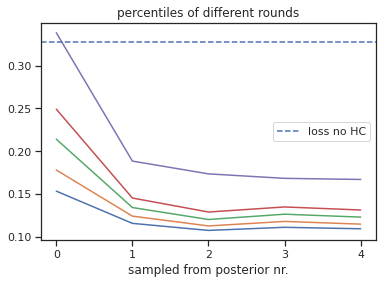

In [100]:
"""
decide here which round to take as final posterior
"""

nrounds = 5

percentiles = np.zeros((nrounds,5))
ps = [0.01,0.1,1,5,50]
for i in range(nrounds):
    percentiles[i,0] = np.percentile(tds[i][1],ps[0])
    percentiles[i,1] = np.percentile(tds[i][1],ps[1])
    percentiles[i,2] = np.percentile(tds[i][1],ps[2])
    percentiles[i,3] = np.percentile(tds[i][1],ps[3])
    percentiles[i,4] = np.percentile(tds[i][1],ps[4])

    
plt.title('percentiles of different rounds')
for i in range(percentiles.shape[-1]):
    plt.plot(np.arange(0,5),percentiles[:,i])
    plt.xticks(np.arange(0,5))
    print('percentile : ', ps[i],',    best round :', np.argmin(percentiles[:,i]))
print()
print('take posterior with best 50 p')
#plt.ylim(0.326,0.328)
plt.axhline(0.3272822, ls='--', label='loss no HC')
plt.xlabel('sampled from posterior nr.')

plt.legend()


In [101]:
percentiles

array([[0.15349217, 0.17815003, 0.21408986, 0.24909496, 0.33825279],
       [0.11589978, 0.12432105, 0.13436627, 0.14544942, 0.18853775],
       [0.10766478, 0.1128847 , 0.12039737, 0.12912841, 0.17362963],
       [0.11130347, 0.11815931, 0.1265829 , 0.13503234, 0.1683988 ],
       [0.10957954, 0.11499653, 0.12318741, 0.13148276, 0.16711683]])

old: which_posterior = [3,4,4,2,4,4,3]

new: which_posterior = [4,3,4,3,2,1,4,4 ]


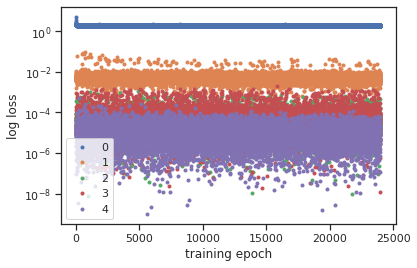

In [242]:
"""
plot loss of training
"""
# only plot every filterns elt
filtern = 10
for i in range(0,5):
    plt.semilogy(logs[i]['loss'][::filtern],'.', label = i)
    #plt.ylim(-0.1,0.2)
    #plt.legend()
    
plt.xlabel('training epoch')
plt.ylabel('log loss')
#plt.ylim(0,0.4)
plt.legend()
plt.show()

Text(0.5, 0, 'round')

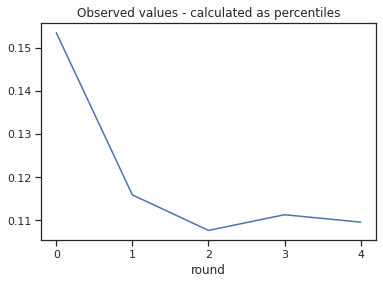

In [103]:
"""
plot pseudo observations
"""

# nr of rounds
n = 5

plt.title('Observed values - calculated as percentiles')

plt.plot(np.arange(0,n),np.array(inf_snpe.pseudo_obs).flatten(), label='run 1')

#plt.ylim(0.32,0.33)
#plt.legend()
plt.xticks(np.arange(0,n))
plt.xlabel('round')
#plt.ylim(0)


Text(0.5, 0, 'round')

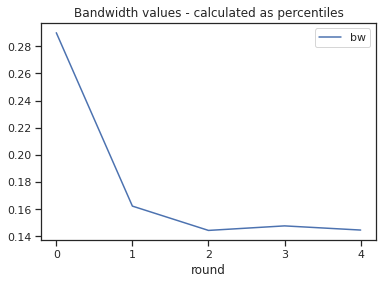

In [104]:
"""
plot bandwidth
"""

# nr of rounds
n =5

plt.title('Bandwidth values - calculated as percentiles')
plt.plot(np.arange(0,n),np.array(inf_snpe.kernel_bandwidth).flatten(), label='bw')
#plt.ylim(-0.1,3.5)

#plt.axhline(2.5 , linestyle='--', color='red', alpha=0.5, label='best value from simple optimization')
plt.legend()
plt.xticks(np.arange(0,n))
plt.xlabel('round')

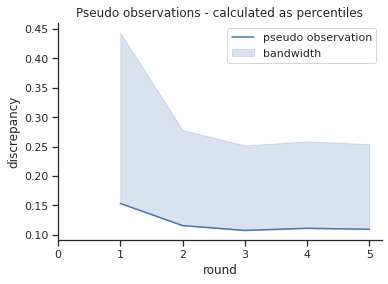

In [105]:
"""
Pseudo observations
one run
"""

colors = ['b','r','g']

sns.set_context("notebook")
#sns.set_style("white")
sns.set_style('ticks')

n = 5


plt.figure(1, figsize=(5.8,4))
plt.title('Pseudo observations - calculated as percentiles')

plt.plot(np.arange(1,n+1),np.array(inf_snpe.pseudo_obs).flatten(), 
              color=colors[0], label='pseudo observation')

#plt.semilogy(np.arange(1,n+1),
#             np.array(SNPE_modellist[zone][0].pseudo_obs).flatten()+SNPE_modellist[zone][0].kernel_bandwidth, 
#             '--',
#             alpha=1,
#             color=colors[zone],
#            label='bandwidth')

plt.fill_between(np.arange(1,n+1),
                 np.array(inf_snpe.pseudo_obs).flatten(), 
             np.array(inf_snpe.pseudo_obs).flatten()+np.array(inf_snpe.kernel_bandwidth).flatten(), 
             alpha=0.2,
             color=colors[0],
            label='bandwidth')


#plt.axhline(x0_list[zone][0] ,
#            xmax=0.96,
#            xmin=0.1,
#            linestyle='dotted', 
#            color=colors[zone], alpha=1, 
#            label='$\\beta$ for final evaluation, '+zonelabels[zone])

plt.legend()
plt.xticks(np.arange(0,n+1))
plt.xlabel('round')
plt.ylabel('discrepancy')
#plt.xlim(0)
sns.despine()

filepath = '/gpfs01/berens/user/cschroeder/Documents/XXX/'
filename = 'pseudo_obs_with_bw_v1.eps'
#plt.savefig(filepath+filename, dpi=300, format='eps',  bbox_inches='tight')

In [108]:
for nround in range(5):
    print('round',nround, np.sum(tds[nround][1]<0.15))

round 0 14
round 1 16041
round 2 52695
round 3 46980
round 4 55479
